### Instructions
In this assignment, you will learn about resampling methods for model evaluation
and attribute selection. You have to predict the crime rate based on a large number of
different attributes.

You can use the SciKit-learn library to fit the linear regressions. The rest of the code
has to be programmed from scratch.

Be careful not to use the same data for training (any stage of training) and testing
your model.

1. **Download the "Communities and Crime" dataset, preprocess the data, and preprocess them so you can use them for linear regression.**

    The last column of the dataset (ViolentCrimesPerPop) is your target variable. Remove the attributes state, county, community, community name, and fold (columns 1 to 5).
    https://archive.ics.uci.edu/dataset/183/communities+and+crime
2. **Implement the cross-validation method and the leave-one-out method.**

    Inside use your own implementation of cross-validation.
3. **Implement forward attribute selection. Fit linear regression.**
4. **Use the attribute selection you implemented to select a reasonable set of attributes for your linear model.**

    Choose a proper metric for the inclusion of attributes (the metric that decides which attribute is most important at each step) and the criteria to stop adding attributes. 
    
    Give reasons for your choice of metric in your report.
5. **Test your model using your independent test set and report the results.**

    Comment on different errors, how do they differ?
6. **Implement the bootstrap method and apply it to the train set to generate 1000 different train sets and train 1000 different linear models.**

    Use only the attributes you selected before.
7. **Use the bootstrapped results to assess the confidence intervals of the performance of the linear model on your independent test set.**
    
    You can use different metrics to assess the performance of the linear model (e.g. MAE, RMS). 
    
    Calculate the confidence intervals for the metric you selected. 


In [135]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from tqdm.notebook import tqdm

In [75]:
# Read the file
with open("communities+and+crime/communities.names", "r") as f:
    text = f.read()

# First we find the relevant block of text
pattern_block = re.compile(
    r"Attribute Information.*?(--.*?)(?:Summary Statistics:|Number of Attributes:|$)",
    re.S | re.I,
)
match_block = pattern_block.search(text)

if not match_block:
    raise ValueError("Couldn't find the 'Attribute Information' block.")

block_text = match_block.group(1)

# Now we extract attribute lines, pattern: -- name: description
pattern_attr = re.compile(r"^--\s*([^:]+):\s*(.*)", re.M)
names_dict = {}
for idx, m in enumerate(pattern_attr.finditer(block_text)):
    name = m.group(1).strip()
    desc = m.group(2).strip()
    names_dict[idx] = [name, desc]

print(f"Extracted {len(names_dict)} attribute descriptions.")
for i in range(10):
    print(i, "->", names_dict.get(i))

Extracted 128 attribute descriptions.
0 -> ['state', 'US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal)']
1 -> ['county', 'numeric code for county - not predictive, and many missing values (numeric)']
2 -> ['community', 'numeric code for community - not predictive and many missing values (numeric)']
3 -> ['communityname', 'community name - not predictive - for information only (string)']
4 -> ['fold', 'fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric)']
5 -> ['population', 'population for community: (numeric - decimal)']
6 -> ['householdsize', 'mean people per household (numeric - decimal)']
7 -> ['racepctblack', 'percentage of population that is african american (numeric - decimal)']
8 -> ['racePctWhite', 'percentage of population that is caucasian (numeric - decimal)']
9 -> ['racePctAsian', 'percentage of population that is of asian heritage (nume

In [76]:
# Load data
data = pd.read_csv("communities+and+crime/communities.data", header=None, na_values="?")
data.columns = [names_dict[i][0] for i in range(len(names_dict))]

print(f"{data.shape[0]} rows and {data.shape[1]} columns in the dataset.\n")

print(f"First few rows of the dataset:")
display(data.head())

print(f"\nData types of each column:\n{data.dtypes}\n")

1994 rows and 128 columns in the dataset.

First few rows of the dataset:


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03



Data types of each column:
state                    int64
county                 float64
community              float64
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr    float64
LemasGangUnitDeploy    float64
LemasPctOfficDrugUn    float64
PolicBudgPerPop        float64
ViolentCrimesPerPop    float64
Length: 128, dtype: object



---
#### Helper functions and classes

In [ ]:
def train_test_split(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    shuffle: bool = True,
    seed: int | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits the dataset into training and testing sets.

    Parameters
    ----------
    X : pd.DataFrame
        Features dataframe.
    y : pd.Series
        Target variable series.
    test_size : float, optional
        Proportion of the dataset to include in the test split (default is 0.2).
    shuffle : bool, optional
        Whether to shuffle the data before splitting (default is True).
    seed : int, optional
        Random seed for reproducibility (default is None).

    Returns
    ----------
    X_train : pd.DataFrame
        Training features dataframe.
    X_test : pd.DataFrame
        Testing features dataframe.
    y_train : pd.Series
        Training target variable series.
    y_test : pd.Series
        Testing target variable series.
    """
    indices = np.arange(len(X))

    # Shuffle
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

    n_test = int(len(X) * test_size)

    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    X_train = X.iloc[train_indices].reset_index(drop=True)
    X_test = X.iloc[test_indices].reset_index(drop=True)
    y_train = y.iloc[train_indices].reset_index(drop=True)
    y_test = y.iloc[test_indices].reset_index(drop=True)

    return X_train, X_test, y_train, y_test


def impute_and_standardize(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame | None = None,
    ordinal_cols: list[str] | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None, dict]:
    """
    Impute and standardize data safely (fit on train, apply to val/test).

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
    X_val : pd.DataFrame, optional
        Validation/test features. If None, only training data is transformed.
    ordinal_cols : list[str], optional
        Columns to impute using mode and skip during scaling.

    Returns
    ----------
    X_train_proc : pd.DataFrame
        Transformed training features.
    X_val_proc : pd.DataFrame | None
        Transformed validation/test features (if provided).
    params : dict
        Dictionary with imputation and scaling parameters:
        {"means": ..., "stds": ..., "modes": ...}
    """

    ordinal_cols = ordinal_cols or []
    indicator_cols = [c for c in X_train.columns if c.endswith("_was_missing")]
    cont_cols = [c for c in X_train.columns if c not in ordinal_cols + indicator_cols]

    X_train_proc = X_train.copy()
    X_val_proc = X_val.copy() if X_val is not None else None

    # 1. Ordinal imputation (mode)
    modes = {}
    for col in ordinal_cols:
        if col in X_train_proc.columns:
            mode_val = X_train_proc[col].mode(dropna=True)
            mode_val = mode_val.iloc[0] if len(mode_val) else 0.0
            modes[col] = mode_val
            X_train_proc[col] = X_train_proc[col].fillna(mode_val)
            if X_val_proc is not None:
                X_val_proc[col] = X_val_proc[col].fillna(mode_val)

    # 2. Continuous imputation (mean)
    means = X_train_proc[cont_cols].mean()
    X_train_proc[cont_cols] = X_train_proc[cont_cols].fillna(means)
    if X_val_proc is not None:
        X_val_proc[cont_cols] = X_val_proc[cont_cols].fillna(means)

    # 3. Standardization (continuous only)
    stds = X_train_proc[cont_cols].std(ddof=0).replace(0, 1)
    X_train_proc[cont_cols] = (X_train_proc[cont_cols] - means) / stds
    if X_val_proc is not None:
        X_val_proc[cont_cols] = (X_val_proc[cont_cols] - means) / stds

    params = {"means": means, "stds": stds, "modes": modes}

    return X_train_proc, X_val_proc, params


def split_into_folds(
    n_samples: int, k: int, shuffle: bool = True, seed: int | None = None
) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Splits indices into k folds for cross-validation.

    Parameters
    ----------
    n_samples : int
        Total number of samples.
    k : int
        Number of folds.
    shuffle : bool, optional
        Whether to shuffle the data before splitting (default is True).
    seed : int, optional
        Random seed for reproducibility (default is None).

    Returns
    ----------
    list[tuple[np.ndarray, np.ndarray]]
        List of (train_indices, val_indices) for each fold.
    """
    if k < 2:
        raise ValueError("Number of folds k must be at least 2.")

    indices = np.arange(n_samples)

    # Shuffle
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

    folds = np.array_split(indices, k)

    return [
        (np.concatenate([folds[j] for j in range(k) if j != i]), folds[i])
        for i in range(k)
    ]


def mse(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Mean squared error

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : pd.Series
        Predicted target values.

    Returns
    ----------
    float
        Mean squared error.
    """
    return float(np.mean((y_true - y_pred) ** 2))


def rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Root mean squared error

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : pd.Series
        Predicted target values.

    Returns
    ----------
    float
        Root mean squared error.
    """
    return float(np.sqrt(mse(y_true, y_pred)))


def mae(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Mean absolute error

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : pd.Series
        Predicted target values.

    Returns
    ----------
    float
        Mean absolute error.
    """
    return float(np.mean(np.abs(y_true - y_pred)))


def r2_score(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    R2 score

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : pd.Series
        Predicted target values.

    Returns
    ----------
    float
        R2 score.
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)

    return np.nan if ss_tot == 0 else float(1 - ss_res / ss_tot)


def closed_form_regression(
    X: pd.DataFrame, y: pd.Series, verbose: bool = False
) -> np.ndarray:
    """
    Closed-form linear regression.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (standardized)
    y : pd.Series
        Target vector
    verbose : bool, optional
        Whether to print messages (default is False).

    Returns
    ----------
    np.ndarray
        Coefficient vector (including intercept as the first element).
    """
    # Column of ones for the intercept term
    X_bias = np.hstack([np.ones((len(X), 1)), X.to_numpy()])

    # Calculate the matrices for the closed-form solution
    XtX = X_bias.T @ X_bias  # X^T X
    Xty = X_bias.T @ y.to_numpy()  # X^T y

    # Invert X^T X
    XtX_inv = np.linalg.pinv(XtX)

    return XtX_inv @ Xty


class ClosedFormLinearRegression:
    """Closed-form linear regression model."""

    def __init__(self) -> None:
        self.coef: np.ndarray | None = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> "ClosedFormLinearRegression":
        """
        Fit the closed-form linear regression model.

        Parameters
        ----------
        X : pd.DataFrame
            Feature matrix.
        y : pd.Series | np.ndarray
            Target variable.

        Returns
        -------
        self : ClosedFormLinearRegression
            Fitted model.
        """
        self.coef = closed_form_regression(X, y)

        return self

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Predict using the linear regression model.

        Parameters
        ----------
        X : pd.DataFrame
            Feature matrix.

        Returns
        -------
        pd.Series
            Predicted target values.
        """
        if self.coef is None:
            raise ValueError("Fit the model first!")

        X_bias = np.hstack([np.ones((X.shape[0], 1)), np.asarray(X)])

        return pd.Series(X_bias @ self.coef)


def cross_val_manual(
    X: pd.DataFrame,
    y: pd.Series,
    k: int = 5,
    ordinal_cols: list[str] | None = None,
    seed: int | None = None,
    folds=None,
) -> dict[str, float]:
    """
    Manual k-fold cross-validation with per-fold imputation and standardization.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    k : int, optional
        Number of folds (default is 5). Use k = len(X) for LOOCV.
    seed : int, optional
        Random seed for reproducibility (default is None).

    Returns
    ----------
    dict[str, float]
        Dictionary of average scores for each metric across folds.
    """
    n = len(X)
    if folds is None:
        folds = split_into_folds(len(X), k=k, shuffle=True, seed=seed)
    is_loocv = k == n

    if is_loocv:
        y_pred_all = np.zeros(n)
    else:
        rmse_list, mae_list, mse_list, r2_list = [], [], [], []

    for train_idx, val_idx in folds:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_proc, X_val_proc, _ = impute_and_standardize(
            X_train, X_val, ordinal_cols
        )

        # Force identical column order
        X_val_proc = X_val_proc[X_train_proc.columns]  # type: ignore

        model = ClosedFormLinearRegression()
        model.fit(X_train_proc, y_train)
        y_pred = model.predict(X_val_proc)

        if is_loocv:
            y_pred_all[val_idx] = y_pred.to_numpy()
        else:
            rmse_list.append(rmse(y_val, y_pred))
            mae_list.append(mae(y_val, y_pred))
            mse_list.append(mse(y_val, y_pred))
            r2_list.append(r2_score(y_val, y_pred))

    if is_loocv:
        return {
            "RMSE": rmse(y, pd.Series(y_pred_all)),
            "MAE": mae(y, pd.Series(y_pred_all)),
            "MSE": mse(y, pd.Series(y_pred_all)),
        }
    else:
        return {
            "RMSE": float(np.mean(rmse_list)),
            "MAE": float(np.mean(mae_list)),
            "MSE": float(np.mean(mse_list)),
            "R2": float(np.mean(r2_list)),
        }


def forward_feature_selection(
    X: pd.DataFrame,
    y: pd.Series,
    k: int = 5,
    max_features: int | None = None,
    metric: str = "RMSE",
    stop_on_no_improve: bool = True,
    min_improvement: float = 1e-4,
    ordinal_cols: list[str] | None = None,
    verbose: bool = False,
    show_progress: bool = False,
    seed: int | None = None,
) -> tuple[list[str], list[float], list[dict[str, float]]]:
    """
    Forward feature selection using custom cross-validation.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    k : int, optional
        Number of folds for cross-validation (default 5).
    max_features : int | None, optional
        Maximum number of features to select (default None = all).
    metric : str, optional
        Metric to optimize ('RMSE', 'MAE', 'MSE', 'R2').
    stop_on_no_improve : bool, optional
        Whether to stop when improvement is below threshold.
    min_improvement : float, optional
        Minimum improvement to continue (default 1e-4).
    ordinal_cols : list[str], optional
        List of ordinal columns for special treatment.
    verbose : bool, optional
        Print progress if True.
    show_progress : bool, optional
        Show tqdm progress bar (default False).
    seed : int | None, optional
        Random seed for reproducibility.

    Returns
    ----------
    selected_features : list[str]
        Selected features in order of inclusion.
    best_scores : list[float]
        Best metric value after each step.
    all_metrics_per_step : list[dict[str, float]]
        Full metrics per selection step.
    """
    metric = metric.upper()
    valid_metrics = {"RMSE", "MAE", "MSE", "R2"}
    if metric not in valid_metrics:
        raise ValueError(f"Metric must be one of {valid_metrics}.")

    selected_features: list[str] = []
    best_scores: list[float] = []
    all_metrics_per_step: list[dict[str, float]] = []

    remaining_features = list(X.columns)
    n_steps = max_features or len(remaining_features)

    iterator = (
        tqdm(range(n_steps), desc="Forward selection progress", leave=True)
        if show_progress
        else range(n_steps)
    )

    prev_best = float("inf") if metric != "R2" else float("-inf")

    # Use the same folds across all selection steps
    folds = split_into_folds(len(X), k=k, shuffle=True, seed=seed)

    for step in iterator:
        best_feature = None
        best_score = float("inf") if metric != "R2" else float("-inf")
        best_metrics: dict[str, float] | None = None

        # Try adding each remaining feature using the same folds
        for feature in remaining_features:
            current_features = selected_features + [feature]
            avg_results = cross_val_manual(
                X[current_features],
                y,
                k=k,
                ordinal_cols=ordinal_cols,
                folds=folds,  # reuse folds
            )

            if np.isnan(avg_results.get(metric, np.nan)):
                continue

            if (metric != "R2" and avg_results[metric] < best_score) or (
                metric == "R2" and avg_results[metric] > best_score
            ):
                best_score = avg_results[metric]
                best_feature = feature
                best_metrics = avg_results

        if best_feature is None:
            if verbose:
                print("No valid feature improved performance. Stopping.")
            break

        improvement = (
            prev_best - best_score if metric != "R2" else best_score - prev_best
        )

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_scores.append(best_score)
        all_metrics_per_step.append(best_metrics if best_metrics else {})
        prev_best = best_score

        if verbose:
            print(
                f"-> Step {len(selected_features)}: Added '{best_feature}', "
                f"{metric}: {best_score:.6f}, diff: {improvement:.3e}"
            )

        # Stop criteria
        if stop_on_no_improve and improvement <= min_improvement and step > 0:
            if verbose:
                print(
                    f"No significant improvement ({improvement:.2e}), "
                    f"stopping after {len(selected_features)} features."
                )
            break

        if len(selected_features) >= n_steps:
            break

    return selected_features, best_scores, all_metrics_per_step


def bootstrap_evaluation(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    n_boot: int = 1000,
    seed: int | None = None,
) -> dict[str, dict[str, np.ndarray]]:
    """
    Perform bootstrap evaluation to estimate confidence intervals for test metrics.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training feature matrix.
    y_train : pd.Series
        Training target variable.
    X_test : pd.DataFrame
        Testing feature matrix.
    y_test : pd.Series
        Testing target variable.
    n_boot : int, optional
        Number of bootstrap samples (default is 1000).
    seed : int | None, optional
        Random seed for reproducibility (default is None).

    Returns
    ----------
    dict[str, dict[str, np.ndarray]]
        Dictionary containing metrics and their 95% confidence intervals.
    """
    rng = np.random.default_rng(seed)
    boot_metrics = {"RMSE": [], "MAE": [], "MSE": [], "R2": []}

    for _ in range(n_boot):
        # Resample training data with replacement
        idx = rng.choice(len(X_train), size=len(X_train), replace=True)
        X_boot = X_train.iloc[idx]
        y_boot = y_train.iloc[idx]

        # Fit closed-form regression on the bootstrap sample
        model = ClosedFormLinearRegression()
        model.fit(X_boot, y_boot)

        # Predict on the same test set
        y_pred = model.predict(X_test)

        # Compute metrics
        boot_metrics["RMSE"].append(rmse(y_test, y_pred))
        boot_metrics["MAE"].append(mae(y_test, y_pred))
        boot_metrics["MSE"].append(mse(y_test, y_pred))
        boot_metrics["R2"].append(r2_score(y_test, y_pred))

    metrics = {k: np.array(v) for k, v in boot_metrics.items()}

    # 95% confidence intervals (2.5th and 97.5th percentiles)
    ci = {k: np.percentile(v, [2.5, 97.5]) for k, v in metrics.items()}

    return {"metrics": metrics, "ci": ci}

---
### Missing values

In [78]:
# Columns that must be excluded
exclude_cols = ["state", "county", "community", "communityname", "fold"]

# Mapping column -> description
name_to_desc = {v[0]: v[1] for v in names_dict.values()}

# Get statistics
desc_stats = data.describe().T[["min", "max", "mean"]]

# Select only columns with missing values
miss_mask = data.isnull().any()
miss_cols = [col for col in data.columns[miss_mask] if col not in exclude_cols]

info = pd.DataFrame(
    {
        "Missing values": data[miss_cols].isnull().sum(),
        "Percentage": round(data[miss_cols].isnull().mean() * 100, 2),
        "Data type": data[miss_cols].dtypes,
        "Min": desc_stats.loc[miss_cols, "min"].values,
        "Max": desc_stats.loc[miss_cols, "max"].values,
        "Mean": desc_stats.loc[miss_cols, "mean"].round(2).values,
        "Description": [name_to_desc.get(col, "N/A") for col in miss_cols],
    }
).sort_values("Missing values", ascending=False)

pd.set_option("display.max_colwidth", None)
print(f"There are {len(miss_cols)} columns with missing values:")
display(info)

There are 23 columns with missing values:


,Missing values,Percentage,Data type,Min,Max,Mean,Description
LemasSwornFT,1675,84.00,float64,0.0,1.0,0.07,number of sworn full time police officers (numeric - decimal)
LemasSwFTPerPop,1675,84.00,float64,0.0,1.0,0.22,sworn full time police officers per 100K population (numeric - decimal)
LemasSwFTFieldOps,1675,84.00,float64,0.0,1.0,0.92,number of sworn full time police officers in field operations (on the street as opposed to administrative etc) (numeric - decimal)
LemasTotalReq,1675,84.00,float64,0.0,1.0,0.10,total requests for police (numeric - decimal)
LemasSwFTFieldPerPop,1675,84.00,float64,0.0,1.0,0.25,sworn full time police officers in field operations (on the street as opposed to administrative etc) per 100K population (numeric - decimal)
LemasTotReqPerPop,1675,84.00,float64,0.0,1.0,0.22,total requests for police per 100K popuation (numeric - decimal)
PolicReqPerOffic,1675,84.00,float64,0.0,1.0,0.34,total requests for police per police officer (numeric - decimal)
OfficAssgnDrugUnits,1675,84.00,float64,0.0,1.0,0.08,number of officers assigned to special drug units (numeric - decimal)
PolicPerPop,1675,84.00,float64,0.0,1.0,0.22,police officers per 100K population (numeric - decimal)
RacialMatchCommPol,1675,84.00,float64,0.0,1.0,0.69,a measure of the racial match between the community and the police force. High values indicate proportions in community and police force are similar (numeric - decimal)


---
### Train/test split

Train shape: (1596, 122), Test shape: (398, 122)
Train target mean: 0.236, Test target mean: 0.245


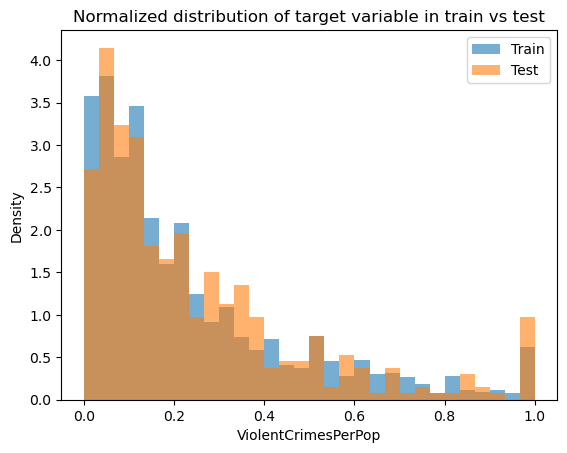

In [124]:
# First we separate features and target and exclude columns that should not be used
X = data.drop(columns=exclude_cols + ["ViolentCrimesPerPop"]).copy()
y = data["ViolentCrimesPerPop"].copy()

# Then we split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# We will now check the distributions of the target variable in the train and test sets to ensure that the random split was representative
print(f"Train target mean: {y_train.mean():.3f}, Test target mean: {y_test.mean():.3f}")

plt.hist(y_train, bins=30, alpha=0.6, label="Train", density=True)
plt.hist(y_test, bins=30, alpha=0.6, label="Test", density=True)
plt.xlabel("ViolentCrimesPerPop")
plt.ylabel("Density")
plt.title("Normalized distribution of target variable in train vs test")
plt.legend()
plt.show()

---
### Preprocessing

We will create two datasets:

- **Full version**: keeps all features with missingness indicators.
- **Reduced version**: drops features with more than 80% missing values.

This way we will test whether retaining highly missing features provides useful information.

#### Full version

In [80]:
# We saw above that the feature 'LemasGangUnitDeploy' is a 3-level ordinal feature (0 for NO, 0.5 for PART-TIME, 1 for YES).
# We will leave it as is, since the numeric encoding already captures the ordinality.
# We will not standardize this feature, because we don't want to change the meaning of its values.
ordinal_cols = ["LemasGangUnitDeploy"]

# We have quite a few features with a lot of missing values. We don't want to lose the potential information they carry, so we will add binary indicators for missingness.
# Then we will impute missing values with the mean of the respective feature from the training set.
miss_cols = [col for col in X_train.columns if X_train[col].isnull().any()]

X_train_full = X_train.copy()
X_test_full = X_test.copy()

# Add missing indicators
for col in miss_cols:
    X_train_full[f"{col}_was_missing"] = X_train_full[col].isnull().astype(int)
    X_test_full[f"{col}_was_missing"] = X_test_full[col].isnull().astype(int)

# Store missing indicators so that we can process them appropriately later
missing_indicators = [
    column for column in X_train_full.columns if column.endswith("_was_missing")
]

print(f"Added missing indicators for {len(miss_cols)} columns.\n")
print(
    f"Old -> new shapes:\n-> Train: {X_train.shape} -> {X_train_full.shape}\n-> Test:  {X_test.shape}  -> {X_test_full.shape}"
)

Added missing indicators for 23 columns.

Old -> new shapes:
-> Train: (1596, 122) -> (1596, 145)
-> Test:  (398, 122)  -> (398, 145)


#### Reduced version

In [81]:
# Threshold for high missingness
MISSING_THRESHOLD = 0.8

# We compute missingness percentages on the training set
miss_percentages = X_train.isnull().mean()

cols_to_drop = miss_percentages[miss_percentages > MISSING_THRESHOLD].index.tolist()

print(
    f"Dropping {len(cols_to_drop)} columns with more than {MISSING_THRESHOLD * 100}% missing values.\n"
)
# display(cols_to_drop) # We exclude all columns with missing values, except the column 'OtherPerCap'

X_train_reduced = X_train.drop(columns=cols_to_drop)
X_test_reduced = X_test.drop(columns=cols_to_drop)

print(
    f"Old -> new shapes:\n-> Train: {X_train.shape} -> {X_train_reduced.shape}\n-> Test:  {X_test.shape}  -> {X_test_reduced.shape}"
)

Dropping 22 columns with more than 80.0% missing values.

Old -> new shapes:
-> Train: (1596, 122) -> (1596, 100)
-> Test:  (398, 122)  -> (398, 100)


#### Imputation and standardization

Function **impute_and_standardize()**:
- Impute ordinal columns using the most frequent value from the training set.
- Impute all continuous columns using the mean from the training set.
- Standardize only the continuous features.

---
### Cross-validation and leave-one-out cross-validation

- We implemented our own k-fold cross-validation function **cross_val_manual()**.
- The leave-one-out method is a special case with k equal to the number of samples.

#### Baseline
- We will run **CV with k = 5** on the full and reduced version without feature selection to get baseline results
- We will run **LOOCV** on the full and reduced version without feature selection to get baseline results

In [82]:
seed = 42

# Baseline results on full dataset with k = 5
results_full_5 = cross_val_manual(
    X_train_full, y_train, k=5, ordinal_cols=ordinal_cols, seed=seed
)

# Baseline results on reduced dataset with k = 5
results_reduced_5 = cross_val_manual(
    X_train_reduced, y_train, k=5, ordinal_cols=ordinal_cols, seed=seed
)

# LOOCV results on full dataset
results_full_loocv = cross_val_manual(
    X_train_full, y_train, k=len(X_train_full), ordinal_cols=ordinal_cols, seed=seed
)

# LOOCV results on reduced dataset
results_reduced_loocv = cross_val_manual(
    X_train_reduced,
    y_train,
    k=len(X_train_reduced),
    ordinal_cols=ordinal_cols,
    seed=seed,
)

In [83]:
# Combined baseline results
results_baseline = {
    "Full k = 5": results_full_5,
    "Reduced k = 5": results_reduced_5,
    "Full LOOCV": results_full_loocv,
    "Reduced LOOCV": results_reduced_loocv,
}

results_baseline_df = pd.DataFrame(results_baseline).round(4)
display(results_baseline_df.fillna("N/A"))

# Rank the methods for each metric
print("\nRanking summary (best is first):\n")

for metric in results_baseline_df.index:
    row = results_baseline_df.loc[metric].dropna()

    # Sort accordingly
    if metric == "R2":
        sorted_row = row.sort_values(ascending=False)
        arrow = "\t> "
    else:
        sorted_row = row.sort_values(ascending=True)
        arrow = "\t< "

    ranking_order = arrow.join(sorted_row.index)
    print(f"{metric}:\t{ranking_order}")

,Full k = 5,Reduced k = 5,Full LOOCV,Reduced LOOCV
RMSE,0.3071,0.3073,0.1377,0.1359
MAE,0.2266,0.2272,0.0975,0.0963
MSE,0.0948,0.0948,0.0189,0.0185
R2,0.6500,0.6489,N/A,N/A



Ranking summary (best is first):

RMSE:	Reduced LOOCV	< Full LOOCV	< Full k = 5	< Reduced k = 5
MAE:	Reduced LOOCV	< Full LOOCV	< Full k = 5	< Reduced k = 5
MSE:	Reduced LOOCV	< Full LOOCV	< Reduced k = 5	< Full k = 5
R2:	Full k = 5	> Reduced k = 5


### Forward feature selection
- We will now use our function **forward_feature_selection()** for forward feature selection. We will use CV with k = 5.
- The goal is to identify which features contribute most to predicting the target variable by iteratively adding the most informative features.
- We need to decide which **evaluation metric** to use when comparing models with different subsets of features.
- To make a choice, we will test the procedure using **each of our available metrics** (RMSE, MAE, MSE, R2) and observe how results differ.
- Later, we will decide which metric provides the most stable and interpretable results for selecting the best set of features.

- We will first test the forward feature selection without stopping criteria and then with it.

In [86]:
metrics_to_test = ["RMSE", "MSE", "MAE", "R2"]
min_improvement = 1e-6
k = 5

selection_results_stop = {}

for metric in tqdm(
    metrics_to_test, desc="Running forward selection for each metric", leave=True
):
    print(f"\nForward feature selection optimizing for {metric}: --------------\n")

    # Full version
    selected_full, scores_full, metrics_full = forward_feature_selection(
        X_train_full,
        y_train,
        k=k,
        metric=metric,
        min_improvement=min_improvement,
        ordinal_cols=ordinal_cols,
        show_progress=True,
        verbose=True,
        seed=seed,
    )

    # Reduced version
    selected_reduced, scores_reduced, metrics_reduced = forward_feature_selection(
        X_train_reduced,
        y_train,
        k=k,
        metric=metric,
        min_improvement=min_improvement,
        ordinal_cols=ordinal_cols,
        show_progress=True,
        verbose=True,
        seed=seed,
    )

    # Save results
    selection_results_stop[metric] = {
        "Full": {
            "features": selected_full,
            "scores": scores_full,
            "all_metrics": metrics_full,
        },
        "Reduced": {
            "features": selected_reduced,
            "scores": scores_reduced,
            "all_metrics": metrics_reduced,
        },
    }

    # Display results
    for version in ["Full", "Reduced"]:
        features = selection_results_stop[metric][version]["features"]
        scores = selection_results_stop[metric][version]["scores"]

        print(f"\n{version} version selected features:")
        for i, (feat, score) in enumerate(zip(features, scores), start=1):
            if feat in missing_indicators:
                feat_desc = f"{feat} (missing indicator)"
            elif feat in cols_to_drop:
                feat_desc = f"{feat} (column with over 80% missing values)"
            else:
                feat_desc = feat
            print(f"{i}. {feat_desc} -> {metric}: {score:.4f}")

Running forward selection for each metric:   0%|          | 0/4 [00:00<?, ?it/s]


Forward feature selection optimizing for RMSE: --------------



Forward selection progress:   0%|          | 0/145 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', RMSE: 0.220825, diff: inf
-> Step 2: Added 'PctPolicHisp', RMSE: 0.220306, diff: 5.185e-04
-> Step 3: Added 'PctEmplManu', RMSE: 0.219890, diff: 4.163e-04
-> Step 4: Added 'agePct65up', RMSE: 0.219553, diff: 3.372e-04
-> Step 5: Added 'PctSameState85', RMSE: 0.219309, diff: 2.438e-04
-> Step 6: Added 'PctVacMore6Mos', RMSE: 0.219231, diff: 7.792e-05
-> Step 7: Added 'OtherPerCap_was_missing', RMSE: 0.219229, diff: 2.026e-06
-> Step 8: Added 'racePctAsian', RMSE: 0.219248, diff: -1.874e-05
No significant improvement (-1.87e-05), stopping after 8 features.


Forward selection progress:   0%|          | 0/100 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', RMSE: 0.220825, diff: inf
-> Step 2: Added 'PctEmplManu', RMSE: 0.220409, diff: 4.161e-04
-> Step 3: Added 'agePct65up', RMSE: 0.220138, diff: 2.709e-04
-> Step 4: Added 'PctVacMore6Mos', RMSE: 0.219971, diff: 1.667e-04
-> Step 5: Added 'PctSameState85', RMSE: 0.219890, diff: 8.088e-05
-> Step 6: Added 'householdsize', RMSE: 0.219873, diff: 1.699e-05
-> Step 7: Added 'PersPerOccupHous', RMSE: 0.220014, diff: -1.405e-04
No significant improvement (-1.40e-04), stopping after 7 features.

Full version selected features:
1. MedOwnCostPctIncNoMtg -> RMSE: 0.2208
2. PctPolicHisp (column with over 80% missing values) -> RMSE: 0.2203
3. PctEmplManu -> RMSE: 0.2199
4. agePct65up -> RMSE: 0.2196
5. PctSameState85 -> RMSE: 0.2193
6. PctVacMore6Mos -> RMSE: 0.2192
7. OtherPerCap_was_missing (missing indicator) -> RMSE: 0.2192
8. racePctAsian -> RMSE: 0.2192

Reduced version selected features:
1. MedOwnCostPctIncNoMtg -> RMSE: 0.2208
2. PctEmplManu -> RMSE:

Forward selection progress:   0%|          | 0/145 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', MSE: 0.049226, diff: inf
-> Step 2: Added 'PctPolicHisp', MSE: 0.049050, diff: 1.754e-04
-> Step 3: Added 'PctEmplManu', MSE: 0.048905, diff: 1.458e-04
-> Step 4: Added 'agePct65up', MSE: 0.048780, diff: 1.247e-04
-> Step 5: Added 'PctSameState85', MSE: 0.048662, diff: 1.182e-04
-> Step 6: Added 'PctVacMore6Mos', MSE: 0.048624, diff: 3.814e-05
-> Step 7: Added 'OtherPerCap_was_missing', MSE: 0.048623, diff: 5.735e-07
No significant improvement (5.74e-07), stopping after 7 features.


Forward selection progress:   0%|          | 0/100 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', MSE: 0.049226, diff: inf
-> Step 2: Added 'PctEmplManu', MSE: 0.049074, diff: 1.519e-04
-> Step 3: Added 'agePct65up', MSE: 0.048972, diff: 1.022e-04
-> Step 4: Added 'PctVacMore6Mos', MSE: 0.048884, diff: 8.728e-05
-> Step 5: Added 'PctSameState85', MSE: 0.048845, diff: 3.899e-05
-> Step 6: Added 'householdsize', MSE: 0.048851, diff: -5.964e-06
No significant improvement (-5.96e-06), stopping after 6 features.

Full version selected features:
1. MedOwnCostPctIncNoMtg -> MSE: 0.0492
2. PctPolicHisp (column with over 80% missing values) -> MSE: 0.0491
3. PctEmplManu -> MSE: 0.0489
4. agePct65up -> MSE: 0.0488
5. PctSameState85 -> MSE: 0.0487
6. PctVacMore6Mos -> MSE: 0.0486
7. OtherPerCap_was_missing (missing indicator) -> MSE: 0.0486

Reduced version selected features:
1. MedOwnCostPctIncNoMtg -> MSE: 0.0492
2. PctEmplManu -> MSE: 0.0491
3. agePct65up -> MSE: 0.0490
4. PctVacMore6Mos -> MSE: 0.0489
5. PctSameState85 -> MSE: 0.0488
6. households

Forward selection progress:   0%|          | 0/145 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', MAE: 0.172111, diff: inf
-> Step 2: Added 'PolicReqPerOffic', MAE: 0.171481, diff: 6.299e-04
-> Step 3: Added 'PctEmplManu', MAE: 0.170819, diff: 6.626e-04
-> Step 4: Added 'PctPolicWhite', MAE: 0.170700, diff: 1.188e-04
-> Step 5: Added 'PctPolicAsian', MAE: 0.170565, diff: 1.353e-04
-> Step 6: Added 'PctSameState85', MAE: 0.170545, diff: 1.941e-05
-> Step 7: Added 'OtherPerCap_was_missing', MAE: 0.170550, diff: -5.100e-06
No significant improvement (-5.10e-06), stopping after 7 features.


Forward selection progress:   0%|          | 0/100 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', MAE: 0.172111, diff: inf
-> Step 2: Added 'PctEmplManu', MAE: 0.171524, diff: 5.872e-04
-> Step 3: Added 'PctVacMore6Mos', MAE: 0.171472, diff: 5.238e-05
-> Step 4: Added 'pctWSocSec', MAE: 0.171311, diff: 1.609e-04
-> Step 5: Added 'PersPerOccupHous', MAE: 0.171188, diff: 1.232e-04
-> Step 6: Added 'householdsize', MAE: 0.171279, diff: -9.115e-05
No significant improvement (-9.12e-05), stopping after 6 features.

Full version selected features:
1. MedOwnCostPctIncNoMtg -> MAE: 0.1721
2. PolicReqPerOffic (column with over 80% missing values) -> MAE: 0.1715
3. PctEmplManu -> MAE: 0.1708
4. PctPolicWhite (column with over 80% missing values) -> MAE: 0.1707
5. PctPolicAsian (column with over 80% missing values) -> MAE: 0.1706
6. PctSameState85 -> MAE: 0.1705
7. OtherPerCap_was_missing (missing indicator) -> MAE: 0.1706

Reduced version selected features:
1. MedOwnCostPctIncNoMtg -> MAE: 0.1721
2. PctEmplManu -> MAE: 0.1715
3. PctVacMore6Mos -> MAE

Forward selection progress:   0%|          | 0/145 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', R2: 0.819043, diff: inf
-> Step 2: Added 'PctPolicHisp', R2: 0.819937, diff: 8.940e-04
-> Step 3: Added 'PctEmplManu', R2: 0.820544, diff: 6.071e-04
-> Step 4: Added 'agePct65up', R2: 0.821004, diff: 4.597e-04
-> Step 5: Added 'PctSameState85', R2: 0.821515, diff: 5.110e-04
-> Step 6: Added 'PctVacMore6Mos', R2: 0.821642, diff: 1.269e-04
-> Step 7: Added 'OtherPerCap_was_missing', R2: 0.821645, diff: 3.401e-06
-> Step 8: Added 'PctPolicAsian', R2: 0.821563, diff: -8.219e-05
No significant improvement (-8.22e-05), stopping after 8 features.


Forward selection progress:   0%|          | 0/100 [00:00<?, ?it/s]

-> Step 1: Added 'MedOwnCostPctIncNoMtg', R2: 0.819043, diff: inf
-> Step 2: Added 'PctEmplManu', R2: 0.819669, diff: 6.259e-04
-> Step 3: Added 'agePct65up', R2: 0.820027, diff: 3.584e-04
-> Step 4: Added 'PctSameState85', R2: 0.820369, diff: 3.424e-04
-> Step 5: Added 'PctVacMore6Mos', R2: 0.820535, diff: 1.652e-04
-> Step 6: Added 'householdsize', R2: 0.820594, diff: 5.904e-05
-> Step 7: Added 'PersPerOccupHous', R2: 0.820357, diff: -2.369e-04
No significant improvement (-2.37e-04), stopping after 7 features.

Full version selected features:
1. MedOwnCostPctIncNoMtg -> R2: 0.8190
2. PctPolicHisp (column with over 80% missing values) -> R2: 0.8199
3. PctEmplManu -> R2: 0.8205
4. agePct65up -> R2: 0.8210
5. PctSameState85 -> R2: 0.8215
6. PctVacMore6Mos -> R2: 0.8216
7. OtherPerCap_was_missing (missing indicator) -> R2: 0.8216
8. PctPolicAsian (column with over 80% missing values) -> R2: 0.8216

Reduced version selected features:
1. MedOwnCostPctIncNoMtg -> R2: 0.8190
2. PctEmplManu -

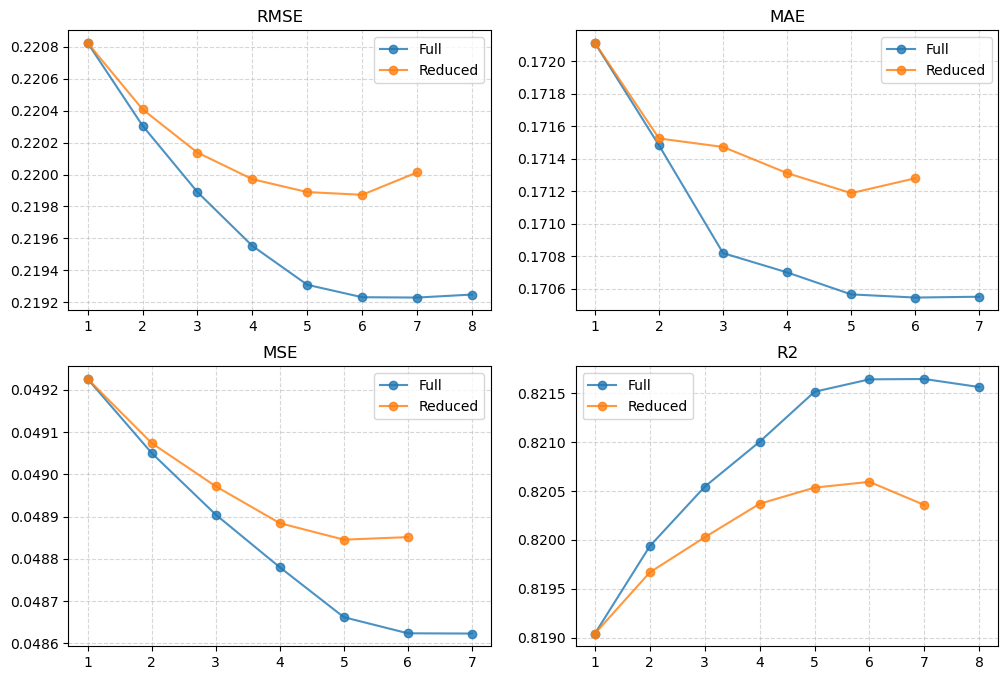

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
axes = ax.ravel()
for i, met in enumerate(["RMSE", "MAE", "MSE", "R2"]):
    for ver in ["Full", "Reduced"]:
        axes[i].plot(
            range(1, len(selection_results_stop[met][ver]["scores"]) + 1),
            selection_results_stop[met][ver]["scores"],
            linestyle="-",
            marker="o",
            label=ver,
            alpha=0.8,
        )
    axes[i].set_title(met)
    axes[i].grid(True, ls="--", alpha=0.5)
    axes[i].legend()

plt.savefig("plots/ffs_stop.png", dpi=300)
plt.show()

In [114]:
# Summary of selected features, final optimized score and other metrics
summary_rows = []

for metric, result in selection_results_stop.items():
    for version in ["Full", "Reduced"]:
        features = result[version]["features"]
        scores = result[version]["scores"]
        all_metrics = result[version]["all_metrics"]

        # Get the last (best) step’s metrics
        final_metrics = all_metrics[-1]

        row = {
            "Metric (optimized)": metric,
            "Dataset": version,
            "# Selected features": len(features),
        }

        for m_name, m_val in final_metrics.items():
            row[f"{m_name} (final)"] = round(m_val, 4)

        row["Selected features"] = ", ".join(features)
        summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by=["Metric (optimized)", "Dataset"]).reset_index(
    drop=True
)
display(summary_df)

,Metric (optimized),Dataset,# Selected features,RMSE (final),MAE (final),MSE (final),R2 (final),Selected features
0,MAE,Full,7,0.2224,0.1706,0.0501,0.8163,"MedOwnCostPctIncNoMtg, PolicReqPerOffic, PctEmplManu, PctPolicWhite, PctPolicAsian, PctSameState85, OtherPerCap_was_missing"
1,MAE,Reduced,6,0.2208,0.1713,0.0492,0.8190,"MedOwnCostPctIncNoMtg, PctEmplManu, PctVacMore6Mos, pctWSocSec, PersPerOccupHous, householdsize"
2,MSE,Full,7,0.2192,0.1714,0.0486,0.8216,"MedOwnCostPctIncNoMtg, PctPolicHisp, PctEmplManu, agePct65up, PctSameState85, PctVacMore6Mos, OtherPerCap_was_missing"
3,MSE,Reduced,6,0.2199,0.1717,0.0489,0.8206,"MedOwnCostPctIncNoMtg, PctEmplManu, agePct65up, PctVacMore6Mos, PctSameState85, householdsize"
4,R2,Full,8,0.2193,0.1714,0.0486,0.8216,"MedOwnCostPctIncNoMtg, PctPolicHisp, PctEmplManu, agePct65up, PctSameState85, PctVacMore6Mos, OtherPerCap_was_missing, PctPolicAsian"
5,R2,Reduced,7,0.2200,0.1718,0.0489,0.8204,"MedOwnCostPctIncNoMtg, PctEmplManu, agePct65up, PctSameState85, PctVacMore6Mos, householdsize, PersPerOccupHous"
6,RMSE,Full,8,0.2192,0.1716,0.0486,0.8215,"MedOwnCostPctIncNoMtg, PctPolicHisp, PctEmplManu, agePct65up, PctSameState85, PctVacMore6Mos, OtherPerCap_was_missing, racePctAsian"
7,RMSE,Reduced,7,0.2200,0.1718,0.0489,0.8204,"MedOwnCostPctIncNoMtg, PctEmplManu, agePct65up, PctVacMore6Mos, PctSameState85, householdsize, PersPerOccupHous"


##### Comment

We used forward feature selection to find the best subset of features for our linear model.
At each step, the model was trained using 5-fold cross-validation and we chose the feature that gave the lowest MSE.

We chose MSE because it reacts strongly to larger errors, so it’s easier to see which features actually improve the model’s accuracy and which just add noise.
The process stopped when adding a new feature didn’t reduce MSE by more than 1e-6.

The final model (optimized on the full dataset) used these seven features:
1. MedOwnCostPctIncNoMtg
2. PctPolicHisp
3. PctEmplManu
4. agePct65up
5. PctSameState85
6. PctVacMore6Mos
7. OtherPerCap_was_missing

Interestingly, one of the selected features was a missing value indicator (OtherPerCap_was_missing), which suggests that the pattern of missing data itself contains some useful information for predicting crime rates.

#### Evaluation on test set

In [125]:
# Final 7 selected features (MSE optimized)
final_features = selection_results_stop["MSE"]["Full"]["features"]
print("Final selected features:")
for f in final_features:
    print(f"- {f}")

Final selected features:
- MedOwnCostPctIncNoMtg
- PctPolicHisp
- PctEmplManu
- agePct65up
- PctSameState85
- PctVacMore6Mos
- OtherPerCap_was_missing


In [131]:
X_train_final_raw = X_train_full[final_features].copy()
X_test_final_raw = X_test_full[final_features].copy()

# Impute and standardize
X_train_final, X_test_final, params_final = impute_and_standardize(
    X_train_final_raw, X_test_final_raw, ordinal_cols=ordinal_cols
)

# Fit final model
final_model = ClosedFormLinearRegression()
final_model.fit(X_train_final, y_train)

# Predict on test set
y_pred_test = final_model.predict(X_test_final)  # type: ignore

# Evaluate metrics
final_rmse = rmse(y_test, y_pred_test)
final_mae = mae(y_test, y_pred_test)
final_mse = mse(y_test, y_pred_test)
final_r2 = r2_score(y_test, y_pred_test)

print("Final model performance on test set:")
print(f"RMSE = {final_rmse:.4f}")
print(f"MAE = {final_mae:.4f}")
print(f"MSE = {final_mse:.4f}")
print(f"R2 = {final_r2:.4f}")

Final model performance on test set:
RMSE = 0.2356
MAE = 0.1770
MSE = 0.0555
R2 = 0.0139


---
### Bootstrap evaluation

In [133]:
# Bootstrap evaluation
bootstrap_results = bootstrap_evaluation(
    X_train_final,
    y_train,
    X_test_final,  # type: ignore
    y_test,
    n_boot=1000,
    seed=42,
)

print("Bootstrap 95% confidence intervals:")
for metric, interval in bootstrap_results["ci"].items():
    mean_val = np.mean(bootstrap_results["metrics"][metric])
    print(
        f"{metric}: mean = {mean_val:.4f}, 95% CI = ({interval[0]:.4f}, {interval[1]:.4f})"
    )

Bootstrap 95% confidence intervals:
RMSE: mean = 0.2361, 95% CI = (0.2348, 0.2378)
MAE: mean = 0.1775, 95% CI = (0.1748, 0.1806)
MSE: mean = 0.0558, 95% CI = (0.0551, 0.0566)
R2: mean = 0.0092, 95% CI = (-0.0053, 0.0199)


In [ ]:
# Relative CI width
for metric, interval in bootstrap_results["ci"].items():
    mean_val = np.mean(bootstrap_results["metrics"][metric])
    ci_width = interval[1] - interval[0]
    relative_width = (ci_width / mean_val) * 100
    print(
        f"{metric}: mean = {mean_val:.4f}, width = {ci_width:.4f}, relative width = {relative_width:.2f}%"
    )

RMSE: mean = 0.2361, width = 0.0030, relative width = 1.27%
MAE: mean = 0.1775, width = 0.0059, relative width = 3.31%
MSE: mean = 0.0558, width = 0.0014, relative width = 2.55%
R2: mean = 0.0092, width = 0.0253, relative width = 275.88%


##### Comment

I trained the final model on the training data and then tested it on the independent test set.

Test results:
- RMSE = 0.2356
- MAE = 0.1770
- MSE = 0.0555
- R2 = 0.0139

The R2 value is very low, meaning the model doesn’t explain much of the variation in crime rates.
However, the predictions are quite consistent. The bootstrap results (1000 samples) showed narrow confidence intervals for RMSE (1.27%) and MAE (3.31%), which means the model’s performance is stable.

MAE shows the average size of the errors, while RMSE and MSE penalize bigger errors more strongly, which is why their values are slightly higher.
Even though the errors are small, the low R2 suggests that crime rates are influenced by more complex or nonlinear factors that a simple linear model can’t capture.

The model is stable but not very strong, which makes sense for this dataset and a basic linear regression approach.